In [1]:
!wget "https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/conv-visualization/data/udacity_sdc.png"

--2019-07-31 21:21:39--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/conv-visualization/data/udacity_sdc.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144560 (141K) [image/png]
Saving to: ‘udacity_sdc.png’

udacity_sdc.png     100%[===================>] 141.17K  --.-KB/s    in 0.02s   

2019-07-31 21:21:40 (8.58 MB/s) - ‘udacity_sdc.png’ saved [144560/144560]



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.image as mpimg

import cv2
import numpy as np
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import torch
import torch.nn.functional as F
# Any results you write to the current directory are saved as output.

CNNs bases their principles in Image feature extraction using Convolutional kernels let's see how this kernels works on and Image and then we will see how to contruct a CNN network using Pytorch

In [3]:

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 3 # lets try to parallelize the data loading
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('input/CIFAR', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('input/CIFAR', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

170500096it [00:06, 28288550.35it/s]                               


Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
# helper function to un-normalize and display an image
def imshow(img,label=None):
    img = img / 2 + 0.5  # unnormalize
    if label:
        plt.title(classes[label])
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

## Visualizing Kernel effects
let's se how convolutions affects our Images 

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

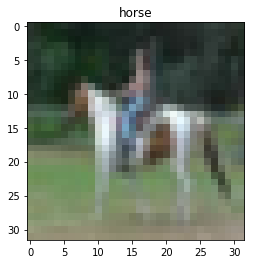

In [6]:
imshow(images[0],labels[0])

In the following cell you can be able to see how applying a particular filter (Convolutional kernel) will affect an image filtering out unrelevant features or emphasizing particular ones, in this case applying the sobel_y filter will emphasize horizontal lines and filtersout other features.

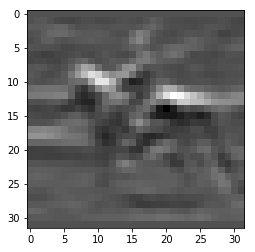

In [7]:
# 3x3 array for edge detection
sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])
# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
filtered_image = cv2.filter2D(images[0].numpy()[0], -1, sobel_y)
plt.imshow(filtered_image, cmap='gray')

To see it clear let's actually write a convolutional layer to see the outputs it's produce and also how the activation function affect the results

So let's say we have the following images and filters gray scale image

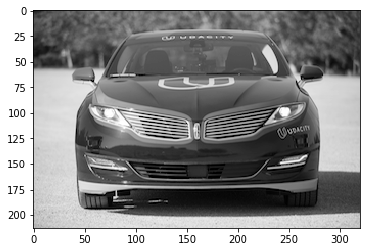

In [8]:
bgr_img = cv2.imread("udacity_sdc.png") # we normalize the image to ly into 0-1 range so tat our filters and sGD will work better
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY).astype("float32")/255
plt.imshow(gray_img,cmap='gray')
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1).float()

Then we have 4 filters one for left vertical lines, other for right vertical lines and others 2 for horizontal lines

In [9]:
right_V = np.array([[-1, -1, 1, 1],
                    [-1, -1, 1, 1],
                    [-1, -1, 1, 1],
                    [-1, -1, 1, 1]])
left_V = -right_V
down_H = right_V.T
up_H = -down_H
filters = np.array([right_V, left_V, down_H, up_H])

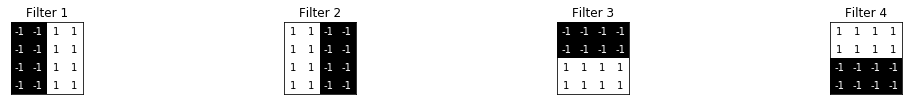

In [10]:
"""
Cite: taken from udacity/deep-learning-v2-pytorch
"""
def viz_filters(filters):
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
    for i in range(4):
        ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i], cmap='gray')
        ax.set_title('Filter %s' % str(i+1))
        width, height = filters[i].shape
        for x in range(width):
            for y in range(height):
                ax.annotate(str(filters[i][x][y]), xy=(y,x),
                            horizontalalignment='center',
                            verticalalignment='center',
                            color='white' if filters[i][x][y]<0 else 'black')
viz_filters(filters)

then we will create a conv layer that uses this filters as conv kernels

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class convtest(torch.nn.Module):
    def __init__(self,weights):
        super().__init__()
        kernel_height,kernels_width=weights.shape[-2:] #the last two are the rows and columns of the kernels
        #we input 1 "feature map(image) 1 dimension", we have 4 filters so we output 4 feature maps
        self.convLayer1=nn.Conv2d(1, 4, kernel_size=(kernel_height, kernels_width), bias=False)
        #we replace the weights with custom filters
        self.convLayer1.weight = torch.nn.Parameter(weights)
        # define a pooling layer
        self.maxPool = nn.MaxPool2d(2, 2)#maxpooling with stride 2 and window of size 2x2 we speact to have the a half of the size o the input
        self.averagePool=nn.AvgPool2d(2,2)#Avgpooling with stride 2 and window of size 2x2 we speact to have the a half of the size o the input
    def forward(self,inputs):
        convolved=self.convLayer1(inputs)
        withActivation=F.relu(convolved)
        maxPooled=self.maxPool(withActivation)
        avgPooled=self.averagePool(withActivation)
        return convolved,withActivation,maxPooled,avgPooled

we will create the layers, cast our filters to 

In [12]:
weights = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = convtest(weights)
model

convtest(
  (convLayer1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (averagePool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [13]:
# helper function for visualizing the output of a given layer
# default number of filters is 4
def viz_layer(layer, n_filters= 4,title=''):
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(title,y=0.6)
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title(f"Output {i+1}")

Conv Layer Output Shape:             torch.Size([1, 4, 210, 317])
Activated Conv Output Shape:         torch.Size([1, 4, 210, 317])
MaxPooling Output Shape:             torch.Size([1, 4, 105, 158])
AveragePooling Output Shape:         torch.Size([1, 4, 105, 158])


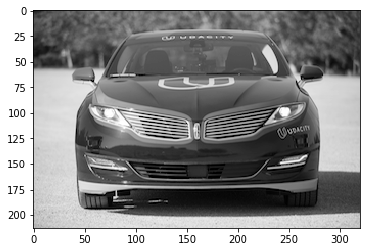

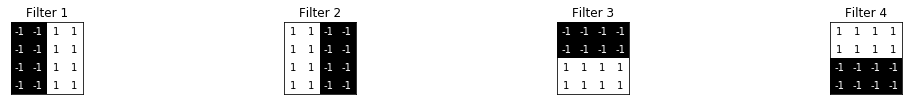

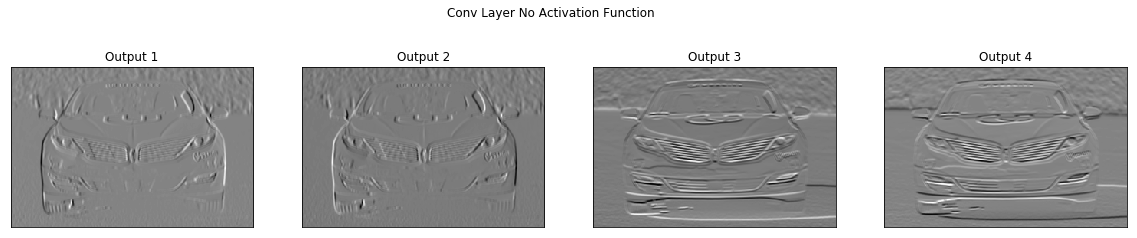

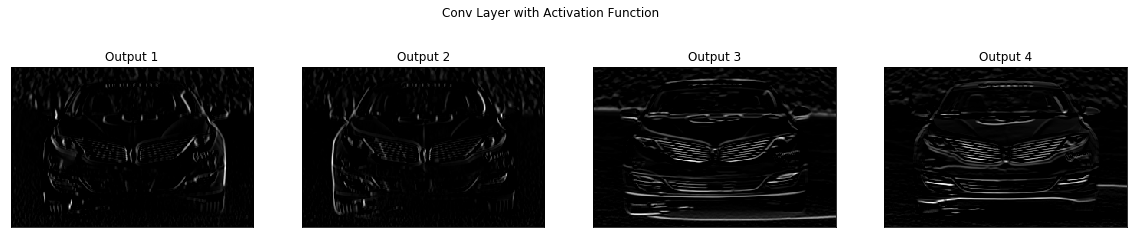

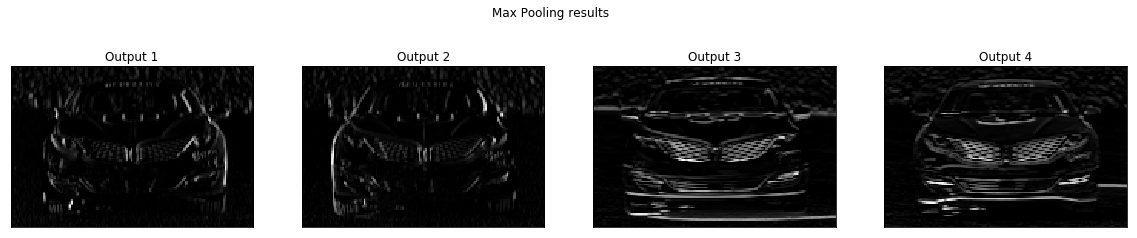

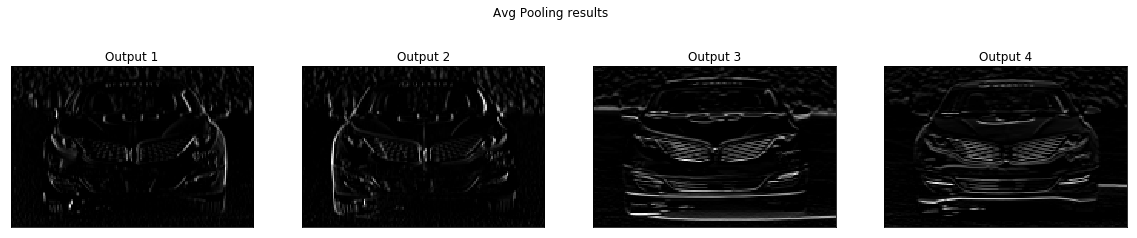

In [14]:
# plot original image
plt.imshow(gray_img, cmap='gray')

viz_filters(model.convLayer1.weight.squeeze(1).detach().int().numpy())
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)
# get the convolutional layer (pre and post activation)
conv_layer, activated_layer,maxPooled,avgPooled = model(gray_img_tensor)
# visualize the output of a conv layer
viz_layer(conv_layer,title='Conv Layer No Activation Function')
viz_layer(activated_layer,title='Conv Layer with Activation Function')
viz_layer(maxPooled,title='Max Pooling results')
viz_layer(avgPooled,title='Avg Pooling results')
print(f"Conv Layer Output Shape: {str(conv_layer.shape):>40}")
print(f"Activated Conv Output Shape: {str(activated_layer.shape):>36}")
print(f"MaxPooling Output Shape: {str(maxPooled.shape):>40}")
print(f"AveragePooling Output Shape: {str(avgPooled.shape):>36}")



Now let's build a network to classify the images in the CIFAR dataset and see the kernels that our network will learn

For image classification tasks we usually want to increase the depth of our features but to decrease its size to create a bootleneck for compressing information obtaining a hicherical structure of the features going from general to particular

- In our case we are going to **increase** by the double the number of kernels to get more feature maps trought each convLayer **16 features--> 32 features--> 64 features** 
- then we will **downsample** the features **HxW** by a half each layer using MaxPooling to extract the most important features for classification **size(32x32) --> size (16x16) --> size (8x8) --> size (4x4)**
- At the end we will perfom the classification flattening our output feature maps and passing it throught a fully connected network so the input of the fc network will be 
$$n_{features} = depth*height*width$$

    where depth is the number of feature maps coming and usually height and weight are the same value and could be calculated as
   $$(height  | width)=\frac{input_{(height|width)}}{P_{1}.stride*P_{2}.stride....*P_{n}.stride}$$
  
  where P refers to the pooling layers applied until the desired output sequencially , remember pooling layers each time their are applied downsample our height|weight by a factor of the stride size (2 a half,1 maintain the same size, etc...)
    

In [50]:
from tqdm.auto import tqdm,trange
class metrics():
    def __init__(self):
        self.loss=[]
        self.accuracy=[]
    def append(self,loss,accuracy):
        self.loss.append(loss)
        self.accuracy.append(accuracy)

class CIFARNET(torch.nn.Module):
    def __init__(self,input_d,size):#size assuming H and W are the same (32x32)
        super().__init__()
        """
        the First Layer will have 16 kernels with size 3 
        an stride of 1 to preserve te size and a padding of 1 to complete the missing pixels of the 3x3 kernels
        """
        self.conv1=nn.Conv2d(input_d,16,kernel_size=3,stride=1,padding=1)#sees (32x32)x3 
        self.conv2=nn.Conv2d(self.conv1.out_channels,32,kernel_size=3,stride=1,padding=1)#sees (16x16)x16 image tensor we've downsample the HxW with maxpooling a half
        self.conv3=nn.Conv2d(self.conv2.out_channels,64,kernel_size=3,stride=1,padding=1)#sees (8x8)x32 image tensor  we've downsample the HxW with maxpooling a half
        self.maxPooling=nn.MaxPool2d(2,2)#window size 2,stride 2 downsample the features height and weight to a half of their size
        """The fc network recieves a flatten tensor of size 64(feature maps)*height*width 
        where this H and w has been downsample by a factor of 2 each time we applied MaxPooling with stride 2
        so the input image has a size of 32x32 pixels then the feature smaps of conv1 16x16, then 8x8 and finaly 4*4
        """
        fc_input_f=self.conv3.out_channels*((size//(self.maxPooling.stride**3))**2)
        self.fc=nn.Sequential(#sees (4x4)x64 image tensor we've downsample the HxW with maxpooling a half
                      nn.Linear(fc_input_f,512),
                      nn.ReLU(),
                      nn.Linear(512,256),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(256,10),
                      nn.LogSoftmax(dim=1)
                      )
        """ we can also don't use activation an use crossentropy loss 
        but cross entropy loss applies logsoftmax and Nlloss so is more efficient to use Logsofmax 
        and NLLoss, and then just use torch.exp to get the actual probabilities"""
    
    def forward(self,inputs):
        h_1=self.maxPooling(F.relu(self.conv1(inputs)))#feature maps by the conv1 max pooled (16x16)x16  
        h_2=self.maxPooling(F.relu(self.conv2(h_1))) #feature maps by the conv2 max pooled (8x8)x32
        h_3=self.maxPooling(F.relu(self.conv3(h_2))) #feature maps by the conv3 max pooled (4x4)x64  
        h_3_flatten=h_3.view(-1,self.fc._modules['0'].in_features)# conv3 feature maps flattened (64 * 4 * 4) , we have already calculated in is the in-features of fc layer
        return self.fc(h_3_flatten) #log probabilities for each class (we must use exp to get the actual probabilities
    
    
    def fit(self,train_generator,val_generator,criterion,Optimizer,faccuracy,Epochs=10,device='cuda'):
        self.to(device)
        train_batches=len(train_generator)
        val_batches=len(val_generator)
        val_metrics,train_metrics = metrics(),metrics()
        for epoch in trange(Epochs,desc='Epochs:'):
            #Train steps
            self.train()
            train_accuracy,train_loss=0,0
            for images,labels in tqdm(train_generator,desc='Train Steps:',leave=False):
                images,labels=images.to(device),labels.to(device)
                Optimizer.zero_grad()#clean the gradients of optimizer
                logProbs=self.forward(images)#calculate logProbabilities 
                loss=criterion(logProbs,labels)#calculating loss
                loss.backward()#Calculating loss gradient with respect the parameters
                Optimizer.step()#Optimization step (backpropagation)
                train_loss+=loss.item()
                train_accuracy+=faccuracy(torch.exp(logProbs),labels).item()
            train_metrics.append(train_loss/train_batches,train_accuracy/train_batches)
            #Validation steps
            self.eval()#turns off dropout 
            val_accuracy,val_loss=0,0
            for images,labels in tqdm(val_generator,desc='Val Steps:',leave=False):
                with torch.no_grad():
                    images,labels=images.to(device),labels.to(device)
                    logProbs=self.forward(images)
                    val_loss+=criterion(logProbs,labels).item()
                    val_accuracy+=faccuracy(torch.exp(logProbs),labels).item()
            val_metrics.append(val_loss/val_batches,val_accuracy/val_batches)
            print(f"EPOCH: {epoch}"
                  f"\nTrain loss: {train_metrics.loss[-1]:.4f} Train accuracy: {train_metrics.accuracy[-1]:.4f}"
                  f"\nVal loss: {val_metrics.loss[-1]:.4f} Val accuracy: {val_metrics.accuracy[-1]:.4f}")
        return train_metrics,val_metrics

In [51]:
images.shape

torch.Size([20, 3, 32, 32])

In [52]:
model=CIFARNET(images.shape[1],images.shape[2])
print("Model Description: ",model,"\nTest model\n",torch.sum(torch.exp(model(images)),dim=1))

Model Description:  CIFARNET(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.3)
    (5): Linear(in_features=256, out_features=10, bias=True)
    (6): LogSoftmax()
  )
) 
Test model
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<SumBackward2>)


Let's train and test our mode

In [57]:
import matplotlib.pyplot as plt
def plot_train_history(train_metrics,val_metrics):
    train_loss,train_accuracy = train_metrics.loss,train_metrics.accuracy
    val_loss,val_accuracy = val_metrics.loss,val_metrics.accuracy
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    plt.plot(train_accuracy, label='Training accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.legend(frameon=False)
    plt.show()

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def f_accuracy(predictions,labels):
    top_p, top_class = predictions.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))
criterion=nn.NLLLoss()
Optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [55]:
train_metrics,val_metrics=model.fit(train_loader,valid_loader,criterion,Optimizer,f_accuracy)

EPOCH: 0
Train loss: 1.5079 Train accuracy: 0.4414
Val loss: 1.1730 Val accuracy: 0.5734


EPOCH: 1
Train loss: 1.0906 Train accuracy: 0.6106
Val loss: 1.0719 Val accuracy: 0.6198


EPOCH: 2
Train loss: 0.8819 Train accuracy: 0.6892
Val loss: 0.9393 Val accuracy: 0.6761


EPOCH: 3
Train loss: 0.7458 Train accuracy: 0.7394
Val loss: 0.8515 Val accuracy: 0.7099


EPOCH: 4
Train loss: 0.6430 Train accuracy: 0.7751
Val loss: 0.8764 Val accuracy: 0.7074


EPOCH: 5
Train loss: 0.5472 Train accuracy: 0.8081
Val loss: 0.8786 Val accuracy: 0.7193


EPOCH: 6
Train loss: 0.4632 Train accuracy: 0.8371
Val loss: 0.9451 Val accuracy: 0.7193


EPOCH: 7
Train loss: 0.3884 Train accuracy: 0.8619
Val loss: 1.0867 Val accuracy: 0.6995


EPOCH: 8
Train loss: 0.3307 Train accuracy: 0.8836
Val loss: 1.1107 Val accuracy: 0.7075


EPOCH: 9
Train loss: 0.2943 Train accuracy: 0.8966
Val loss: 1.1593 Val accuracy: 0.7184


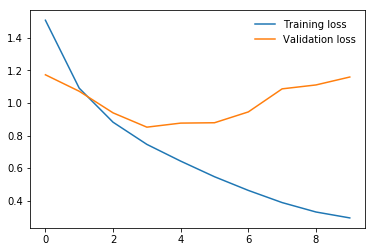

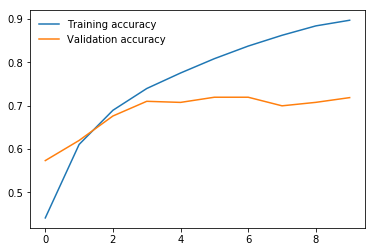

In [58]:
plot_train_history(train_metrics,val_metrics)

There is a serious overfitting in our model let's try to fix it using some regularization techniques later...